[INFO] Label distribution:
label
1    2557
0    1417
Name: count, dtype: int64
[OK] Saved events → level48_events.csv
[OK] Saved CV results → level48_cv_results.csv

=== Summary ===
Baseline LogReg      | ROC-AUC: 0.508±0.045 | PR-AUC: 0.660±0.020
Inverse-Freq LogReg  | ROC-AUC: 0.503±0.033 | PR-AUC: 0.653±0.025
GBM Focal-Style      | ROC-AUC: 0.478±0.018 | PR-AUC: 0.642±0.044


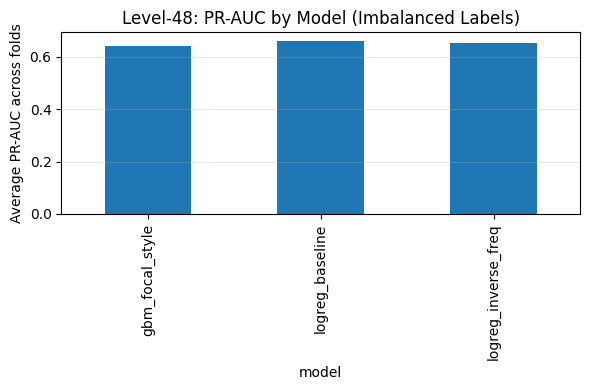

In [1]:
# level48_class_imbalance.py
# Level-48 — Class Imbalance Handling (Weights & Focal-Style Loss)
#
# - Builds imbalanced labels from forward returns.
# - Uses PurgedKFold + embargo to avoid leakage.
# - Compares:
#     (a) Baseline Logistic Regression
#     (b) Weighted Logistic Regression (class_weight='balanced')
#     (c) GradientBoostingClassifier with focal-style sample weights.
#
# DSA Concept:
# 1) Class counts via bincount / value_counts (O(n)).
# 2) Sample weights as inverse-frequency (w_k ∝ 1 / freq_k).
# 3) Focal-style weights use model probabilities: harder examples get higher weight.
#    This is implemented via vectorized operations (no Python loops over samples).

import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Iterator, Tuple, Dict, Any

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import BaseCrossValidator
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# yfinance is optional; synthetic fallback if unavailable or failing.
try:
    import yfinance as yf
except ImportError:
    yf = None


# -------------------- Config -------------------- #

@dataclass
class Config:
    symbol: str = "SPY"
    start: str = "2010-01-01"

    # Labeling parameters
    horizon: int = 20              # forward horizon in bars
    pos_threshold: float = 0.005   # label 1 if fwd_ret > this; ensures imbalance

    # CV / leakage guard
    n_splits: int = 5
    embargo_pct: float = 0.01

    # Synthetic fallback
    synthetic_len: int = 252 * 10
    random_state: int = 42

    # Outputs
    out_events_csv: str = "level48_events.csv"
    out_cv_csv: str = "level48_cv_results.csv"


# -------------------- Data & Labels -------------------- #

def generate_synthetic_series(cfg: Config) -> pd.DataFrame:
    """
    Synthetic GBM-like series as offline fallback.
    DSA: vectorized generation of log-returns and cumulative sum.
    """
    np.random.seed(cfg.random_state)
    n = cfg.synthetic_len
    idx = pd.date_range(start=cfg.start, periods=n, freq="B")

    mu = 0.08 / 252.0
    sigma = 0.20 / np.sqrt(252.0)
    ret = np.random.normal(mu, sigma, size=n)

    price0 = 100.0
    price = price0 * np.exp(np.cumsum(ret))

    df = pd.DataFrame({"close": price, "ret": ret}, index=idx)
    print("[WARN] Using synthetic GBM-like series instead of real market data.")
    return df


def load_price_series(cfg: Config) -> pd.DataFrame:
    """
    Try yfinance; if it fails (timeout, no internet, weird columns),
    fall back to synthetic series.

    Returns DataFrame with ['close', 'ret'].
    """
    if yf is None:
        print("[WARN] yfinance not installed. Falling back to synthetic time series.")
        return generate_synthetic_series(cfg)

    try:
        px = yf.download(cfg.symbol, start=cfg.start, auto_adjust=True, progress=False)
    except Exception as e:
        print(f"[WARN] yfinance download failed ({e}). Falling back to synthetic series.")
        return generate_synthetic_series(cfg)

    if px is None or px.empty:
        print("[WARN] yfinance returned empty DataFrame. Falling back to synthetic series.")
        return generate_synthetic_series(cfg)

    # Try 'Close'; fall back to 'Adj Close' if needed
    if "Close" in px.columns:
        close_obj = px["Close"]
    elif "Adj Close" in px.columns:
        close_obj = px["Adj Close"]
    else:
        print("[WARN] No 'Close'/'Adj Close' column. Falling back to synthetic series.")
        return generate_synthetic_series(cfg)

    # Handle MultiIndex columns (DataFrame) vs Series
    if isinstance(close_obj, pd.DataFrame):
        close_series = close_obj.iloc[:, 0].astype(float)
    else:
        close_series = close_obj.astype(float)

    close_series = close_series.rename("close")
    ret = np.log(close_series).diff().rename("ret")

    df = pd.concat([close_series, ret], axis=1).dropna()
    return df


def build_forward_labels(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    """
    Forward horizon labels with an explicit threshold to create imbalance.

    y = 1 if fwd_ret > cfg.pos_threshold, else 0.

    DSA:
    - rolling(window=horizon).sum() is a sliding window / prefix-sum based operation.
    - shift(-horizon + 1) aligns the forward window end with the current index.
    """
    h = cfg.horizon

    fwd_ret = df["ret"].rolling(window=h).sum().shift(-h + 1)
    fwd_ret = fwd_ret.rename("fwd_ret")

    t1 = df.index.to_series().shift(-h + 1)
    t1.name = "t1"

    events = pd.concat([df["close"], df["ret"], fwd_ret, t1], axis=1)
    events = events.dropna(subset=["fwd_ret", "t1"])

    y = (events["fwd_ret"] > cfg.pos_threshold).astype(int).rename("label")
    events = events.join(y)

    return events


# -------------------- Purged K-Fold CV -------------------- #

class PurgedKFold(BaseCrossValidator):
    """
    Purged K-Fold with embargo for event-based financial data.

    DSA:
    - We treat each index position as a "node" with an interval [start, end=t1[i]].
    - For each test fold, we:
        1. Build a mask for test indices (contiguous in time).
        2. Apply an embargo mask after the test region.
        3. For each train candidate, check interval overlap with the test window:
           [train_start, train_end] overlaps [test_start, test_end]?
           -> vectorized boolean operations on arrays (O(n)).
    """

    def __init__(self, n_splits: int = 5, embargo_pct: float = 0.0, t1: pd.Series = None):
        if n_splits < 2:
            raise ValueError("n_splits must be at least 2.")
        self.n_splits = n_splits
        self.embargo_pct = float(embargo_pct)
        self.t1 = t1

    def get_n_splits(self, X=None, y=None, groups=None) -> int:
        return self.n_splits

    def split(self, X, y=None, groups=None) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        if self.t1 is None:
            raise ValueError("PurgedKFold requires t1 to be set.")
        if not isinstance(X, (pd.DataFrame, pd.Series)):
            raise TypeError("X must be a pandas DataFrame/Series with an Index.")

        idx = np.array(X.index)
        t1 = self.t1.reindex(idx)
        if t1.isna().any():
            raise ValueError("t1 must have non-null values for all X indices.")

        n = len(idx)
        indices = np.arange(n)

        fold_sizes = np.full(self.n_splits, n // self.n_splits, dtype=int)
        fold_sizes[: n % self.n_splits] += 1

        current = 0
        n_embargo = int(np.ceil(self.embargo_pct * n))

        for fold_size in fold_sizes:
            start = current
            stop = current + fold_size
            current = stop

            test_mask = np.zeros(n, dtype=bool)
            test_mask[start:stop] = True
            test_idx = indices[test_mask]

            embargo_mask = np.zeros(n, dtype=bool)
            if n_embargo > 0:
                emb_start = stop
                emb_end = min(n, stop + n_embargo)
                embargo_mask[emb_start:emb_end] = True

            train_mask = ~(test_mask | embargo_mask)
            train_candidates = indices[train_mask]

            test_start_time = idx[start]
            test_end_time = t1.iloc[test_idx].max()

            train_starts = idx[train_candidates]
            train_ends = t1.iloc[train_candidates].values

            overlap = (train_starts <= test_end_time) & (train_ends >= test_start_time)
            final_train = train_candidates[~overlap]

            yield final_train, test_idx


# -------------------- Metrics & Weights -------------------- #

def sharpe_ratio(returns: pd.Series, ann_factor: int = 252) -> float:
    if returns is None or len(returns) < 2:
        return 0.0
    mu = float(returns.mean())
    sigma = float(returns.std())
    if sigma <= 0:
        return 0.0
    return mu / sigma * np.sqrt(ann_factor)


def make_inverse_freq_weights(y: np.ndarray) -> np.ndarray:
    """
    Inverse class-frequency weights.
    DSA:
    - bincount -> O(n_classes + n_samples) to get counts.
    - weights = 1 / freq[y_i] via vectorized indexing.
    """
    y = np.asarray(y, dtype=int)
    classes, counts = np.unique(y, return_counts=True)
    freq = dict(zip(classes, counts))
    w = np.zeros_like(y, dtype=float)
    for c in classes:
        w[y == c] = 1.0 / freq[c]
    # normalize for numerical stability
    w *= float(len(y)) / np.sum(w)
    return w


def make_focal_weights(y: np.ndarray, p: np.ndarray, alpha: float = 0.25, gamma: float = 2.0) -> np.ndarray:
    """
    Focal-style weights (adapted from Focal Loss).

    p: model probability of y=1.
    For each sample:
        p_t = p   if y==1
        p_t = 1-p if y==0
        w_i = alpha*(1-p_t)^gamma                 if y==1
            = (1-alpha)*(1-p_t)^gamma             if y==0

    DSA:
    - All operations vectorized: no Python loops over samples.
    """
    y = np.asarray(y, dtype=int)
    p = np.asarray(p, dtype=float)

    p = np.clip(p, 1e-6, 1 - 1e-6)
    p_t = np.where(y == 1, p, 1.0 - p)

    alpha_vec = np.where(y == 1, alpha, 1.0 - alpha)
    w = alpha_vec * np.power(1.0 - p_t, gamma)

    # normalize weights
    w *= float(len(w)) / np.sum(w)
    return w


def evaluate_model_cv(
    model: BaseEstimator,
    X: pd.DataFrame,
    y: np.ndarray,
    cv: BaseCrossValidator,
    sample_weight: np.ndarray | None = None,
    label: str = ""
) -> Dict[str, Any]:
    """
    Manual CV loop so we can pass sample_weight to fit().

    For each fold:
      - fit on train with (optional) sample_weight_train
      - compute ROC-AUC + PR-AUC on test
    """
    metrics = []
    fold_id = 1

    for train_idx, test_idx in cv.split(X, y):
        clf = clone(model)

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if sample_weight is not None:
            sw_train = sample_weight[train_idx]
            clf.fit(X_train, y_train, sample_weight=sw_train)
        else:
            clf.fit(X_train, y_train)

        prob = clf.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, prob)
        pr = average_precision_score(y_test, prob)

        metrics.append({"fold": fold_id, "roc_auc": roc, "pr_auc": pr})
        fold_id += 1

    df = pd.DataFrame(metrics)
    df["roc_auc_mean"] = df["roc_auc"].mean()
    df["roc_auc_std"] = df["roc_auc"].std()
    df["pr_auc_mean"] = df["pr_auc"].mean()
    df["pr_auc_std"] = df["pr_auc"].std()
    df["model"] = label
    return {
        "df": df,
        "metrics": {
            "roc_auc_mean": df["roc_auc_mean"].iloc[0],
            "roc_auc_std": df["roc_auc_std"].iloc[0],
            "pr_auc_mean": df["pr_auc_mean"].iloc[0],
            "pr_auc_std": df["pr_auc_std"].iloc[0],
        },
    }


# -------------------- Demo Pipeline -------------------- #

def run_demo(cfg: Config) -> None:
    # 1) Load price series (real or synthetic)
    df = load_price_series(cfg)

    # 2) Build imbalanced labels
    events = build_forward_labels(df, cfg)
    print("[INFO] Label distribution:")
    print(events["label"].value_counts(dropna=False))

    # 3) Features: lagged returns + rolling volatility
    max_lag = 5
    feature_cols = []

    for lag in range(1, max_lag + 1):
        col = events["ret"].shift(lag).rename(f"ret_lag{lag}")
        feature_cols.append(col)

    roll_vol = events["ret"].rolling(window=20).std().rename("roll_vol20")
    feature_cols.append(roll_vol)

    X = pd.concat(feature_cols, axis=1).dropna()
    y = events.loc[X.index, "label"].values
    t1 = events.loc[X.index, "t1"]

    # 4) CV splitter
    cv = PurgedKFold(
        n_splits=cfg.n_splits,
        embargo_pct=cfg.embargo_pct,
        t1=t1
    )

    # 5) Models
    base_logreg = LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=300,
        random_state=cfg.random_state
    )

    # 6) Baseline (no weights)
    res_base = evaluate_model_cv(
        model=base_logreg,
        X=X,
        y=y,
        cv=cv,
        sample_weight=None,
        label="logreg_baseline"
    )

    # 7) Balanced weights via inverse frequency (class_weight-like)
    w_inv = make_inverse_freq_weights(y)
    res_weighted = evaluate_model_cv(
        model=base_logreg,
        X=X,
        y=y,
        cv=cv,
        sample_weight=w_inv,
        label="logreg_inverse_freq"
    )

    # 8) Focal-style weights with Gradient Boosting
    #    First build global probabilities from a baseline model (no CV; just illustration).
    base_logreg_full = clone(base_logreg)
    base_logreg_full.fit(X, y)
    p_full = base_logreg_full.predict_proba(X)[:, 1]
    w_focal = make_focal_weights(y, p_full, alpha=0.25, gamma=2.0)

    gbm = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=cfg.random_state
    )

    res_focal = evaluate_model_cv(
        model=gbm,
        X=X,
        y=y,
        cv=cv,
        sample_weight=w_focal,
        label="gbm_focal_style"
    )

    # 9) Combine and save results
    df_cv_all = pd.concat(
        [res_base["df"], res_weighted["df"], res_focal["df"]],
        ignore_index=True
    )
    df_cv_all.to_csv(cfg.out_cv_csv, index=False)

    events.to_csv(cfg.out_events_csv, index_label="timestamp")

    print(f"[OK] Saved events → {cfg.out_events_csv}")
    print(f"[OK] Saved CV results → {cfg.out_cv_csv}")

    print("\n=== Summary ===")
    for name, res in [
        ("Baseline LogReg", res_base),
        ("Inverse-Freq LogReg", res_weighted),
        ("GBM Focal-Style", res_focal),
    ]:
        m = res["metrics"]
        print(
            f"{name:20s} | ROC-AUC: {m['roc_auc_mean']:.3f}±{m['roc_auc_std']:.3f} "
            f"| PR-AUC: {m['pr_auc_mean']:.3f}±{m['pr_auc_std']:.3f}"
        )

    # 10) Quick plot of PR-AUC by model
    summary = df_cv_all.groupby("model")[["roc_auc", "pr_auc"]].mean()
    plt.figure(figsize=(6, 4))
    summary["pr_auc"].plot(kind="bar")
    plt.title("Level-48: PR-AUC by Model (Imbalanced Labels)")
    plt.ylabel("Average PR-AUC across folds")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# -------------------- Main -------------------- #

def main():
    cfg = Config()
    run_demo(cfg)


if __name__ == "__main__":
    # Jupyter-safe: strip kernel args like -f kernel-XXXX.json
    import sys
    sys.argv = [sys.argv[0]]
    main()
